Problem1 : Plot E, H field for z, t when l1 =0.25 * 700, l2=0.5 * 700

In [93]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from meep.materials import SiO2

resolution = 100  # pixels/um

sz = 1  # size of cell in X direction
sx = 2  # size of cell in Y direction
cell = mp.Vector3(sx, 0, sz)

dpml = 0.25
pml_layers = [mp.PML(dpml,direction=mp.X)]

In [94]:
l1 = 0.25*0.7
l2 = 0.5*0.7

Si = mp.Medium(epsilon=11.8)

In [95]:
geometry = [
    #SiO2
    mp.Block(
        size=mp.Vector3(l1, mp.inf,mp.inf),
        center=mp.Vector3(-l1/2, 0, 0),
        material=SiO2,
    ),
    #Si
    mp.Block(
        size=mp.Vector3(1, mp.inf,mp.inf),
        center=mp.Vector3(1/2, 0, 0),
        material=Si,
    )
]

In [96]:
fcen = 0.15  # pulse center frequency
df = 0.1  # pulse width (in frequency)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(-0.5 * sx + dpml, wvg_ycen, 0),
        size=mp.Vector3(0, w, 0),
    )
]

     block, center = (-0.0875,0,0)
          size (0.175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0.5,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.8,11.8,11.8)


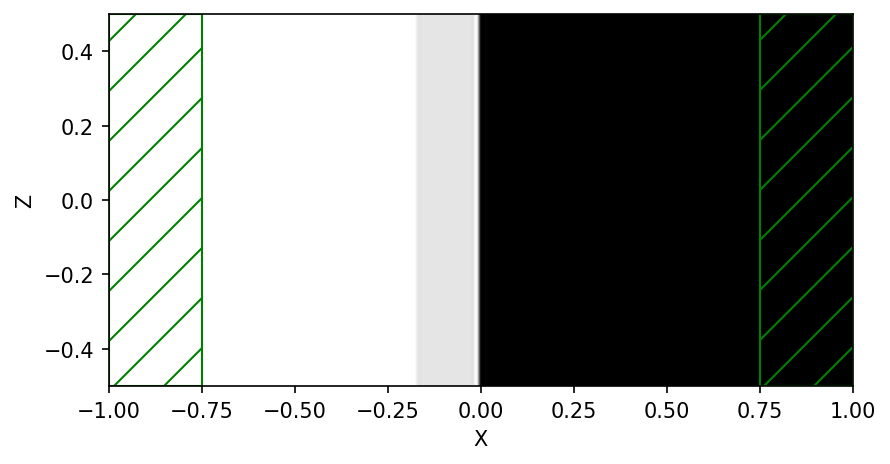

In [97]:
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

nfreq = 100  # number of frequencies at which to compute flux

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-0.5 * sx + dpml + 0.5, wvg_ycen, 0), size=mp.Vector3(0, 2 * w, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml, wvg_ycen, 0), size=mp.Vector3(0, 2 * w, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

In [54]:

pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 3D dimensions.
Computational cell is 2 x 0.1 x 1 with resolution 10
     block, center = (0,-11.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.000906944 s
-----------


RuntimeError: meep: Source width > cell width in y direction!


In [24]:
# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00041604 s
Working in 2D dimensions.
Computational cell is 16 x 32 x 0 with resolution 10
     block, center = (-2,-11.5,0)
          size (12,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (3.5,2,0)
          size (1,28,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.042547 s
-----------
field decay(t = 50.050000000000004): 1.6976522694449e-10 / 1.6976522694449e-10 = 1.0
field decay(t = 100.05000000000001): 4.691071063910552e-07 / 4.691071063910552e-07 = 1.0
field decay(t = 150.1): 2.9928727336864534e-07 / 4.691071063910552e-07 = 0.6379934758847049
field decay(t = 200.15): 0.003927813565272275 / 0.003927813565272275 = 1.0
field decay(t = 250.20000000000002): 0.00015009081939073958 / 0.003927813565272275 = 0.03821230740627969
field decay(t = 300.2):

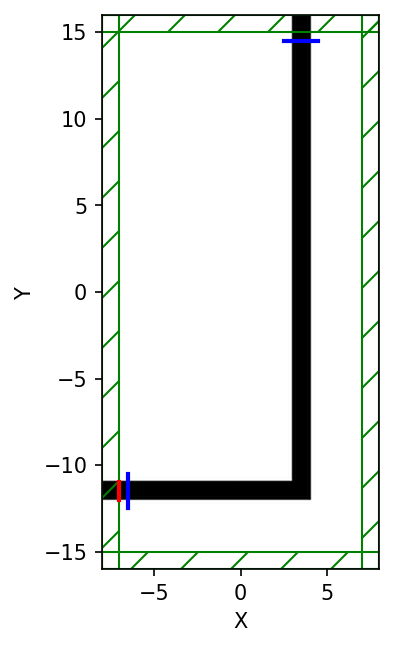

In [25]:
sim.reset_meep()

geometry = [
    mp.Block(
        mp.Vector3(sx - pad, w, mp.inf),
        center=mp.Vector3(-0.5 * pad, wvg_ycen),
        material=mp.Medium(epsilon=12),
    ),
    mp.Block(
        mp.Vector3(w, sy - pad, mp.inf),
        center=mp.Vector3(wvg_xcen, 0.5 * pad),
        material=mp.Medium(epsilon=12),
    ),
]

sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran_fr = mp.FluxRegion(
    center=mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5, 0), size=mp.Vector3(2 * w, 0, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(wvg_xcen, 0.5 * sy - dpml - 0.5)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D()
plt.show()

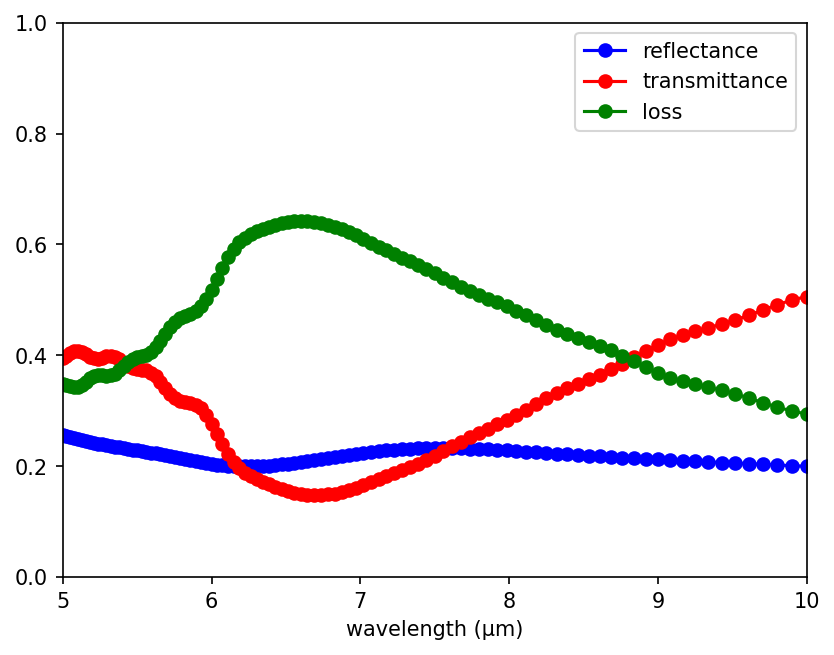

In [26]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / flux_freqs[i])
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([5.0, 10.0, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()